In [1]:
from pyspark.sql.functions import split, col, when, lit, concat, array, struct, array_distinct, substring, expr, size, regexp_replace
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from google.colab import drive

In [2]:
from pyspark.sql.functions import split, col, when, lit, concat, array, struct, array_distinct, substring, expr, size, regexp_replace, udf # Importing udf here
from pyspark.sql import functions as F
from pyspark.sql.types import StringType # Importing StringType here
from google.colab import drive

In [3]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Configura Spark
spark = SparkSession.builder.appName("Optimized Spark on Colab").master("local[*]").config("spark.executor.memory", "4g").config("spark.driver.memory", "8g").config("spark.executor.cores", "2").config("spark.driver.maxResultSize", "4g").getOrCreate()

# Verifica configurazione
spark.sparkContext.getConf().getAll()
#######################
# Create a Spark session
file_path = "/content/drive/Shareddrives/DDAM/Datasets aggiornati/df_cluster.csv"

# Load the CSV dataset into a DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+--------------------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|          topic_name|
+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+-------

In [19]:
# Taking the text file in order to map the MO codes into meaningful text.
mapping_file = "/content/drive/Shareddrives/DDAM/3_Research_Question/MO_CODES_explanation.txt"

mapping_dict = {}
with open(mapping_file, 'r') as f:
    for line in f:
        line = line.strip()  # To remove redundant spaces
        if not line:  # if empty
            continue
        try:
            key, value = line.split(None, 1)
            mapping_dict[key] = value
        except ValueError:
            print(f"Riga mal formattata: '{line}'")

In [20]:
# Broadcasting the dictionary: good for sharing static, read-only data efficiently across a Spark cluster
broadcast_mapping = spark.sparkContext.broadcast(mapping_dict)

In [21]:
#  Creating a function that maps codes into text
def map_code_to_word(codes):
    if codes is None or codes.strip() == "":
        return "No Code"  # O un valore predefinito
    code_list = codes.split(" ")
    meanings = [broadcast_mapping.value.get(code, "Unknown Code") for code in code_list]
    return " ".join(meanings)
map_udf = udf(map_code_to_word, StringType())

# Updating the DataFrame
df_with_words = df.withColumn("Meaning", map_udf(df["MOCODES"]))
df_with_words.select('Mocodes','Meaning').show(truncate=False)

+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mocodes                      |Meaning                                                                                                                                                          |
+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1822 0100 0344               |Stranger Suspect Impersonate Removes vict property                                                                                                               |
|0344                         |Removes vict property                                                                                                                                            |
|0522 1258 0602 0360 0551 0913

In [22]:
df_with_words = df_with_words.select('AREA NAME','DR_NO','Premis Desc','Weapon Desc','Meaning','Vict Sex','Vict Descent','time_of_day','season','topic_name')

In [23]:
df = df_with_words.withColumn("Weapon_Desc_Updated", F.regexp_replace("Weapon Desc", "NO WEAP", "NO_WEAP"))
df = df.withColumn("text", F.concat_ws(" ", F.col("Premis Desc"), F.col("Weapon_Desc_Updated"), F.col("Meaning"),F.col("AREA NAME"),F.col("Vict Sex"),F.col("Vict Descent"),F.col("time_of_day"),F.col("season")))

In [24]:
#df1 = df.select('DR_NO','text')

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df = tokenizer.transform(df)
df.show(1, truncate = False)
#df = df.select('DR_NO','tokens','text')

# Stopwords removal step (Some terms were added manually after some trials)
custom_stopwords = {"vict", "susp", "-", "etc", "no_weap", "&", "mo", ")", "(", "any", "also","is/was", "w/", "crm", "agnst", "victim", "victim's", "thru", "b/w", "use", "uses", "used"}
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
all_stopwords = list(set(default_stopwords).union(custom_stopwords))
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
remover = remover.setStopWords(all_stopwords)

#Update step
df = remover.transform(df)
df.show(1, truncate = False)
#df = df.select('DR_NO','filtered_tokens')

# Vectorizer step: after this step, now data are ready to be processed by clustering algorithm.
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
model = vectorizer.fit(df)
df = model.transform(df)
df.select('DR_NO','features','filtered_tokens', 'topic_name').show()

+---------+---------+----------------------+-----------+--------------------------------------------------+--------+----------------------+-----------+------+-----------------------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|AREA NAME|DR_NO    |Premis Desc           |Weapon Desc|Meaning                                           |Vict Sex|Vict Descent          |time_of_day|season|topic_name                               |Weapon_Desc_Updated|text                                                                                                                             |tokens                                                                                                                                           |
+-----

In [25]:
# prompt: show me the proportion of the column topic_name

from pyspark.sql.functions import count, col

# Calculate proportions for 'topic_name' column
topic_proportions = df.groupBy("topic_name").agg(count("*").alias("count")) \
    .withColumn("proportion", col("count") / df.count())

# Display the results
topic_proportions.show()

+--------------------+------+--------------------+
|          topic_name| count|          proportion|
+--------------------+------+--------------------+
|Hate Crimes and B...| 13184|0.013416944999073921|
|Violent Home Intr...|  7146|0.007272260995402172|
|     Sexual Offenses| 15047|0.015312861908454588|
|Shoplifting and M...| 52366|0.053291242553208815|
|Violent Robberies...| 32897| 0.03347824936548353|
|Protection of Fam...| 61883| 0.06297639619066228|
|Violent Assaults ...|119191| 0.12129695778099361|
|Vandalism and Veh...|100746| 0.10252605740873037|
|Crimes Against Mi...|  1506|0.001532609160240...|
|Crimes in Health ...|  2124|0.002161528457071...|
|Vehicle Theft and...|193769|  0.1971926589445961|
|Vandalism Targeti...| 87561| 0.08910809474089136|
|     Armed Robberies| 35879|0.036512937623010715|
|Domestic Violence...| 71044| 0.07229925974774026|
|Trespassing or Le...| 18968|0.019303141136410358|
|Security in Publi...|  2020|0.002055690905501314|
|Identity and Prop...| 65018| 0

CNN with LDA topic

In [26]:
df.select('DR_NO','features','filtered_tokens', 'topic_name').show(truncate = False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+
|DR_NO    |features                                                                                                                                                                                                         |filtered_tokens                                                                                                                                                                                                              

In [27]:
from pyspark.sql.functions import col
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Estrazione delle colonne necessarie
filtered_tokens_rdd = df.select("filtered_tokens", "topic_name").rdd

# Conversione in liste per TensorFlow
texts = filtered_tokens_rdd.map(lambda row: " ".join(row["filtered_tokens"])).collect()
labels = filtered_tokens_rdd.map(lambda row: row["topic_name"]).collect()

# Codifica delle etichette in numeri
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenizzazione e sequenze
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding delle sequenze
padded_sequences = pad_sequences(sequences, maxlen=100, padding="post", truncating="post")

# Divisione train-test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Conversione delle etichette in una rappresentazione categoriale
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Costruzione della CNN con dropout e regolarizzazione L2
l2 = tf.keras.regularizers.L2(0.01)  # Regolarizzazione L2 con peso 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation="softmax"),
])

# Compilazione del modello
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Addestramento del modello
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
)

# Valutazione del modello
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1538s 62ms/step - accuracy: 0.7019 - loss: 1.2901 - val_accuracy: 0.8239 - val_loss: 0.7790
Epoch 2/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1569s 62ms/step - accuracy: 0.7984 - loss: 0.9086 - val_accuracy: 0.8345 - val_loss: 0.7381
Epoch 3/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1571s 62ms/step - accuracy: 0.8041 - loss: 0.8787 - val_accuracy: 0.8361 - val_loss: 0.7335
Epoch 4/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1517s 61ms/step - accuracy: 0.8091 - loss: 0.8583 - val_accuracy: 0.8384 - val_loss: 0.7205
Epoch 5/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1533s 62ms/step - accuracy: 0.8106 - loss: 0.8504 - val_accuracy: 0.8414 - val_loss: 0.7013
Epoch 6/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1522s 62ms/step - accuracy: 0.8122 - loss: 0.8459 - val_accuracy: 0.8379 - val_loss: 0.7193
Epoch 7/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1510s 61ms/step - accuracy: 0.8141 - loss: 0.8380 - val_accuracy: 0.8451 - val_loss: 0.6956
Epoch 8/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1565

In [27]:
# Decodifica delle etichette (opzionale: per interpretare i risultati)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)

# Decodifica delle etichette
y_pred_labels = np.argmax(y_pred, axis=1)  # Le etichette predette
y_test_labels = np.argmax(y_test, axis=1)  # Le etichette reali

# Calcolo del classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Stampa il classification report
print(report)

6142/6142 ━━━━━━━━━━━━━━━━━━━━ 107s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                   precision    recall  f1-score   support

                                  Armed Robberies       0.76      0.90      0.83      7202
                     Arson and Public Disturbance       0.00      0.00      0.00       189
                            Crimes Against Minors       0.80      0.58      0.67       310
         Crimes in Health or Religious Facilities       0.74      0.14      0.24       429
 Crimes in Public Transit and Food Establishments       0.86      0.86      0.86      3556
        Domestic Violence and Relational Assaults       0.94      0.94      0.94     14255
             Hate Crimes and Bias-Driven Offenses       0.80      0.80      0.80      2600
        Identity and Property Theft in Residences       0.94      0.89      0.91     12992
                    Minor Thefts in Parking Areas       0.78      0.79      0.78     16446
Protection of Families and Vulnerable Individuals       0.79      0.77      0.78     1228

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


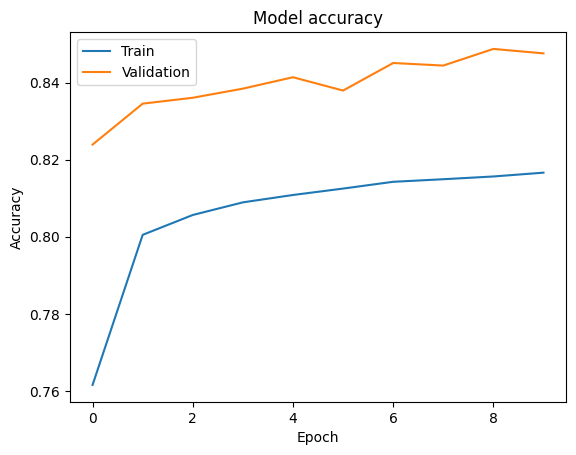

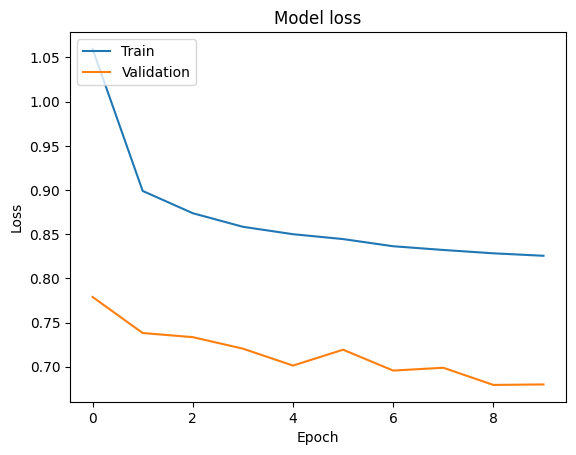

In [29]:
# prompt: print  a learning curve about the previous model

import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from model.fit()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()